# Fit transits with fewest spot occultations


### Open raw FITS files from MAST, clean out `nan`s

Save copies to `raw_long`, `raw_short` directories. 

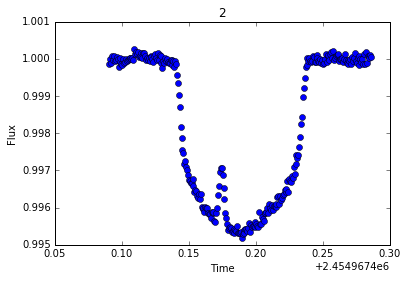

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '../')

import os
from glob import glob
from starspots.lightcurve import LightCurve, concatenate_transit_light_curves
from starspots.systemparams import rough_hat11_params

import numpy as np

# Define where to find the short cadence light curves from MAST (.fits)
path_to_fits_files = '/local/tmp/hat11/'
# Define the rough orbital/planetary/stellar properties of the system
transit_params = rough_hat11_params()

# Retrieve long and short cadence data
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short',
                                    transit_params=transit_params)

# Split up short cadence light curve into list of transit light curves
short_transits = LightCurve(name='transits_short', **short_lc.mask_out_of_transit())
transits = short_transits.get_transit_light_curves()

# Use Leslie's subtract-add-divide method to normalize each transit
quarter_maxes = short_lc.get_quarterly_maxes()
for transit in transits:
    q = transit.quarters[0]
    transit.subtract_add_divide(quarter_maxes[q], order=2, plots=False)
    
# Plot one to check that the normalization worked
transits[2].plot()

## Find "spotless" transits

Do a quick cursory fit to each transit using `scipy.optimize.fmin` to optimize the light curve by changing only the depth. Since transits with few spots will have a small $\tilde{\chi}^2$ -- meaning small or few deviations from the Mandel & Agol model -- and large depth -- after Leslie's subtract-add-divide method, as is usually the case, starspot occultations during transit will bias transit depths upwards. These transits are the "spotless" transits that we'll use to measure the planet's properties for use with STSP.

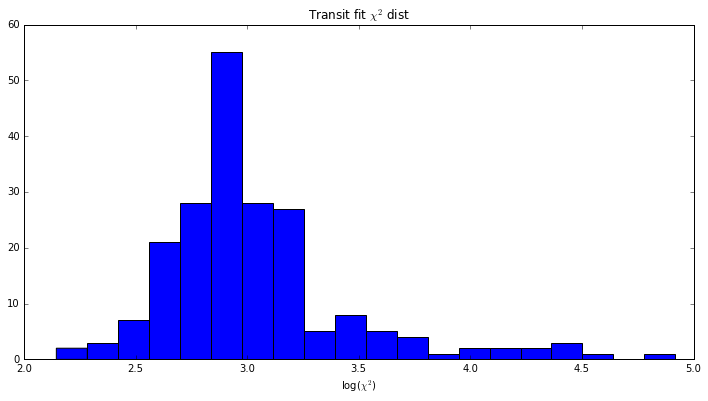

In [2]:
chi2 = []
depths = []
for transit in transits:
    p, chi = transit.fiducial_transit_fit()
    depths.append(p[0])
    chi2.append(chi)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()

# spotless transits: 10


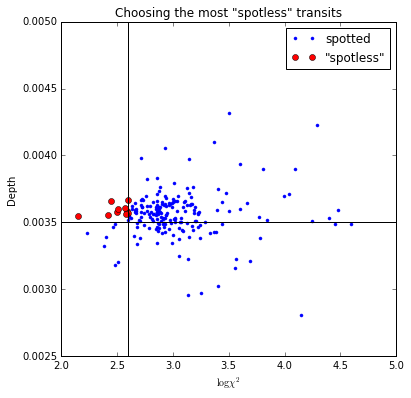

In [3]:
# Set the threshold in (chi^2-depth) space for "spotless" transits
chi2_threshold = 2.5995
depth_threshold = 0.0035

spotless_transit_inds = (np.log(chi2) < chi2_threshold) * (np.array(depths) > depth_threshold)
spotless_transits = concatenate_transit_light_curves([transit for i, transit in enumerate(transits) 
                                                      if spotless_transit_inds[i]], name='spotless_transits')

print('# spotless transits: {}'.format(np.count_nonzero(spotless_transit_inds)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.log(chi2), depths, '.', label='spotted')
ax.plot(np.log(chi2)[spotless_transit_inds], 
        np.array(depths)[spotless_transit_inds], 'ro', label='"spotless"')

ax.axvline(chi2_threshold, color='k')
ax.axhline(depth_threshold, color='k')
ax.legend(loc='upper right')
ax.set(xlabel=r'$\log{\chi^2}$', ylabel=r'Depth', 
       title='Choosing the most "spotless" transits');

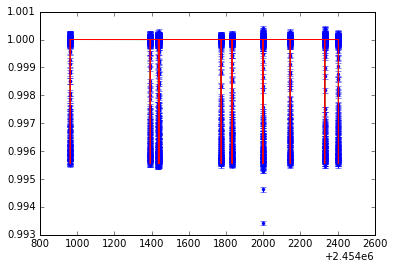

In [4]:
leastsq_fit_params, chi2_spotless = spotless_transits.fiducial_transit_fit(plots=True)

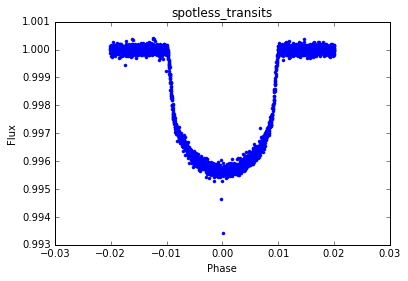

In [5]:
spotless_transits.plot(phase=True, plot_kwargs={'marker':'.', 'lw':0})

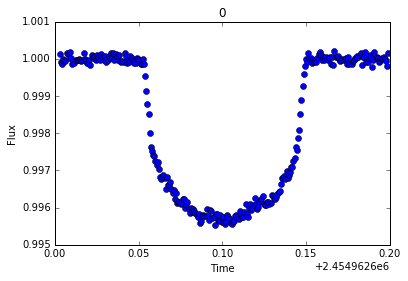

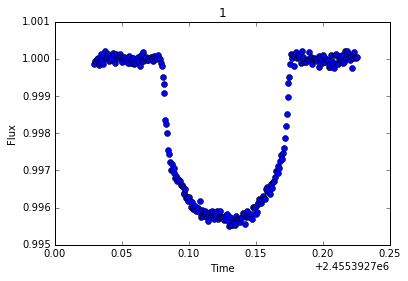

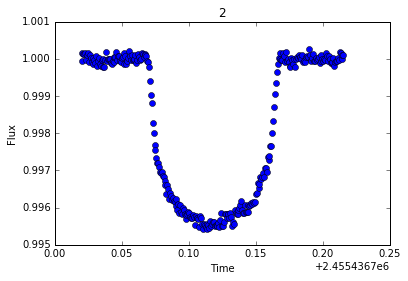

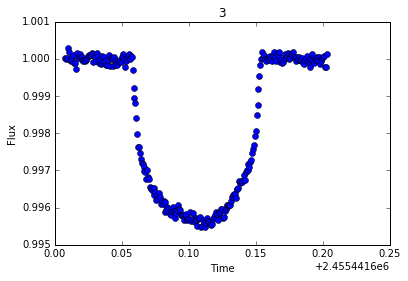

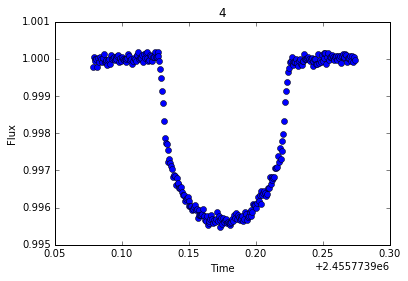

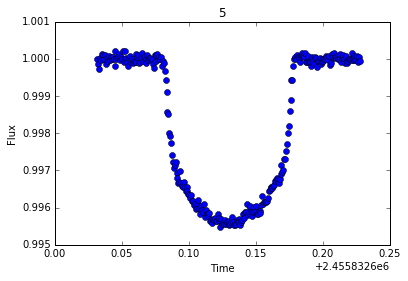

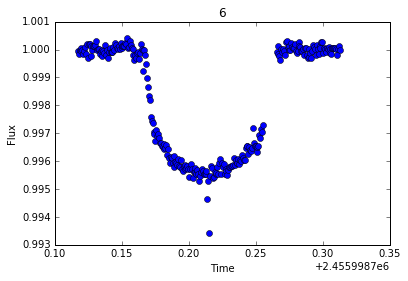

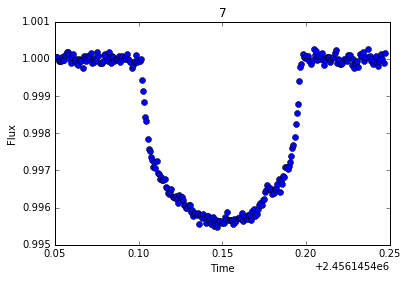

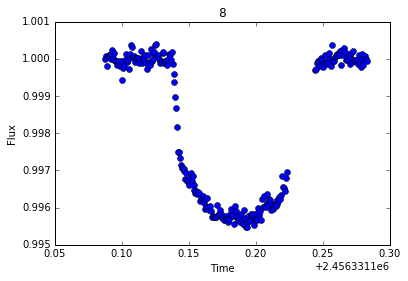

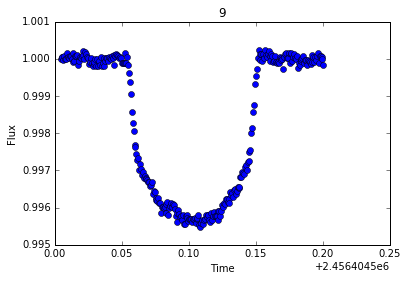

In [6]:
each_spotless_transit = spotless_transits.get_transit_light_curves()

for sptlstr in each_spotless_transit:
    sptlstr.plot()

In [7]:
print("Mean times of three 'spotless' transits: {0}"
      .format([t.times.jd.mean() for t in each_spotless_transit]))

Mean times of three 'spotless' transits: [2454962.7009082013, 2455392.8273756811, 2455436.8176223976, 2455441.7053187271, 2455774.0759595907, 2455832.7296241755, 2455998.912470079, 2456145.5488881255, 2456331.2795661958, 2456404.6023539016]


### Use `emcee` to get PDFs for interesting transit parameters

Here I'm fitting for: $t_0$, depth, duration, impact parameter and Kipping's efficient two-parameter limb-darkening terms $q_1$, $q_2$.

In [8]:
# from starspots.fitting import generate_model_lc_short
# import batman
# params = batman.TransitParams()
# params.t0 = 2454605.89132                       #time of inferior conjunction
# params.per = 4.8878018                     #orbital period
# params.rp = 0.00355**0.5                      #planet radius (in units of stellar radii)
# params.a = 14.2                       #semi-major axis (in units of stellar radii)
# params.b = 0.35
# params.inc = 88.50

# ecosw = 0.261  # Winn 2010
# esinw = 0.085  # Winn 2010
# eccentricity = np.sqrt(ecosw**2 + esinw**2)
# omega = np.degrees(np.arccos(ecosw/eccentricity))

# params.ecc = eccentricity                      #eccentricity
# params.w = omega                       #longitude of periastron (in degrees)

# params.duration = 0.15
# params.u = [0.6136, 0.1062]                #limb darkening coefficients
# params.limb_dark = "quadratic"       #limb darkening model

# plt.plot(transits[0].times.jd, generate_model_lc_short(transits[0].times.jd, params))
# plt.plot(transits[0].times.jd, transits[0].fluxes,'.')
# plt.show()

In [9]:
from starspots.fitting import run_emcee, plot_triangle

def quadratic_to_kipping(u1, u2):
    q1 = (u1 + u2)**2
    q2 = 0.5*u1/(u1 + u2)
    return q1, q2
q1, q2 = quadratic_to_kipping(*transit_params.u)

p0 = [transit_params.t0, transit_params.rp**2, transit_params.duration, 
      transit_params.b, q1, q2]
n_steps = 1500
# n_steps=1000 Takes about ~3 min
samples, sampler = run_emcee(p0, spotless_transits.times.jd, spotless_transits.fluxes, 
                             spotless_transits.errors, n_steps, transit_params)

/astro/users/bmmorris/.local/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/astro/users/bmmorris/.local/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


accept frac = 0.47008


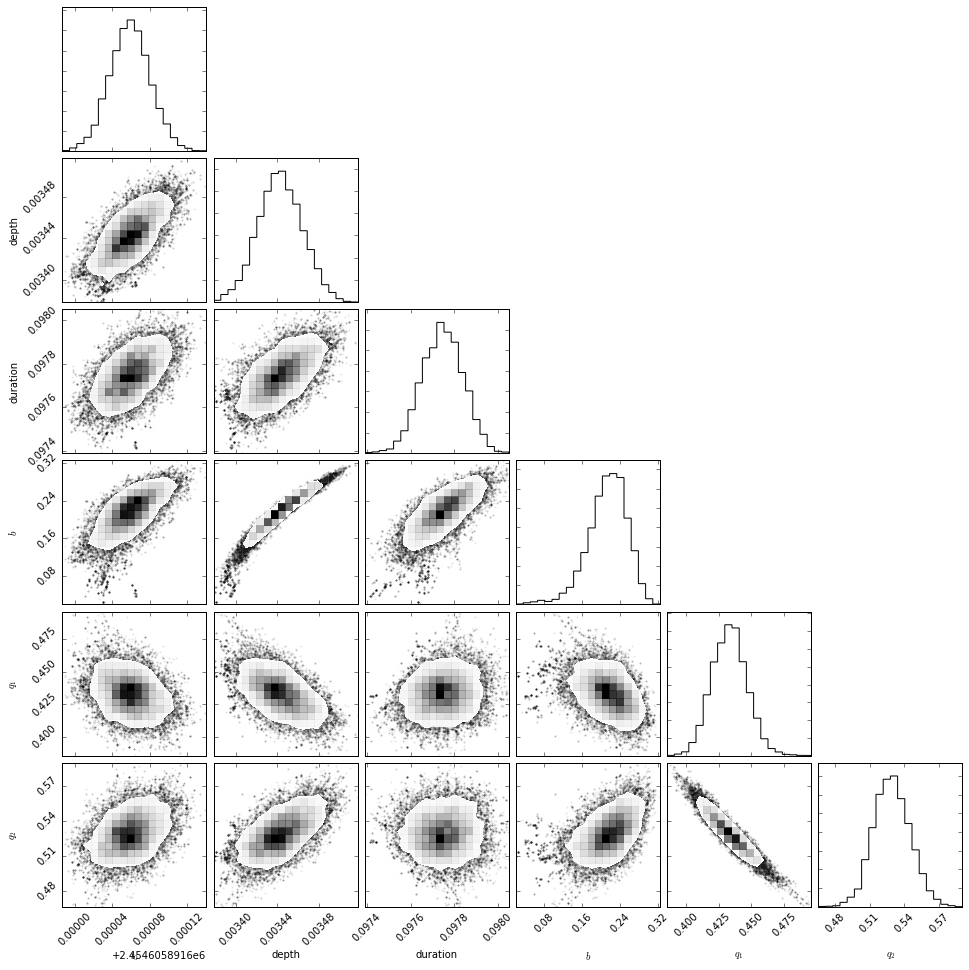

In [10]:
print("accept frac = {0}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples)

In [ ]:
from IPython.display import display_latex, Latex
from starspots.fitting import print_emcee_results
#print_emcee_results(samples)
Latex(print_emcee_results(samples))

<IPython.core.display.Latex object>

### Fit for ephemeris using best-fit parameters from "spotless" fits

In [ ]:
from starspots.fitting import run_emcee_ephemeris
from copy import deepcopy
from starspots.systemparams import aRs_i

depth, dur, b, q1, q2 = np.median(samples[:, 1:], axis=0)
p0 = [np.median(samples[:, 0]), transit_params.per]
#bestfit_transit_params = [depth, dur, b, q1, q2]

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

refined_transit_params = deepcopy(transit_params)
refined_transit_params.rp = depth**0.5
refined_transit_params.duration = dur
refined_transit_params.b = b
refined_transit_params.u = kipping_to_quadratic([q1, q2])
aRs, inc = aRs_i(refined_transit_params)
refined_transit_params.a = aRs
refined_transit_params.inc = inc

n_steps = 1800
samples_eph, sampler_eph = run_emcee_ephemeris(p0, spotless_transits.times.jd, 
                                               spotless_transits.fluxes, 
                                               spotless_transits.errors, 
                                               n_steps, refined_transit_params, 
                                               n_walkers=20)

In [ ]:
plot_triangle(samples_eph)

In [ ]:
for i, p in enumerate(['mid-transit time', 'period']):
    mid, minus, plus = np.percentile(samples_eph[:,i], [50, 16, 84])
    print("{3}: {0:.8f} +{1:.8f} -{2:.8f}".format(mid, plus-mid, mid-minus, p))

Now with new period measurement, fit the spotless transits again. These are the final posteriors.

In [ ]:
p0 = np.median(samples[:, :], axis=0) # [t0, depth, dur, b, q1, q2]
n_steps = 2000
refined_transit_params.per = np.median(samples_eph[:, 1])
# n_steps=1000 Takes about ~3 min
samples_refined, sampler_refined = run_emcee(p0, spotless_transits.times.jd, 
                                             spotless_transits.fluxes, 
                                             spotless_transits.errors, 
                                             n_steps, refined_transit_params,
                                             n_walkers=70)

In [ ]:
print("accept frac = {}".format(np.mean(sampler_refined.acceptance_fraction)))
plot_triangle(samples_refined[:, :])

In [ ]:
Latex(print_emcee_results(samples_refined))

In [ ]:
period_mid, period_minus, period_plus = np.percentile(samples_eph[:,1], [50, 16, 84])
period_upper = period_plus-period_mid
period_lower = period_plus-period_mid
best_fit_period = mid
Latex("$P: {{{0:.8f}}}^{{+{1:.8f}}}_{{-{2:.8f}}}$"
      .format(period_mid, period_plus-period_mid, period_mid-period_minus))

Create LaTeX table for paper

In [ ]:
mid, minus, plus = np.percentile(samples_refined, [50, 16, 84], axis=0)
lower = mid - minus
upper = plus - mid

best_parameter_dict = {'t0': (mid[0], lower[0], upper[0]), 
                       'depth': (mid[1], lower[1], upper[1]), 
                       'duration': (mid[2], lower[2], upper[2]), 
                       'b': (mid[3], lower[3], upper[3]), 
                       'q1': (mid[4], lower[4], upper[4]), 
                       'q2': (mid[5], lower[5], upper[5]), 
                       'P': (period_mid, period_lower, period_upper)}

table_lines = ['$P$ [days] & ${{{0:.7f}}}^{{-{1:.7f}}}_{{+{2:.7f}}}$ \\\\',
                '$T_0$  [BJD] &  ${{{0}}}_{{-{1:0.6f}}}^{{+{2:0.6f}}}$ \\\\',
                '$T_{{14}}$ [days] &  ${{{0:.04f}}}_{{-{1:.04f}}}^{{+{2:.04f}}}$ \\\\',
                '$(R_p / R_s)^2$  &  ${{{0:.5f}}}_{{-{1:.5f}}}^{{+{2:.5f}}}$ \\\\',
                '$b$  &  ${{{0:.03f}}}_{{-{1:.03f}}}^{{+{2:.03f}}} $ \\\\',
                '$q_1$  & ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\',
                '$q_2$  &  ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\']
table_lines_order = ['P', 't0', 'duration', 'depth', 'b', 'q1', 'q2']
table_contents = ""

for line, param_i in zip(table_lines, table_lines_order):
    table_contents += line.format(*best_parameter_dict[param_i]) + '\n'

dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
with open(os.path.join(dropbox_path, 'results', 'hat-11_light_curve_params.txt'), 'w') as param_table:
    param_table.write(table_contents)

In [ ]:
from starspots.systemparams import rough_hat11_params
import batman

depth_refined, dur_refined, b_refined = np.median(samples_refined[:, [1, 2,3]], axis=0)

refined_params = batman.TransitParams()
refined_params.t0 = np.median(samples_refined[:, 0])
refined_params.per = period_mid
refined_params.rp = np.median(samples_refined[:, 1])**0.5
refined_params.duration = np.median(samples_refined[:, 2])
refined_params.b = np.median(samples_refined[:, 3])
refined_params.u = kipping_to_quadratic([np.median(samples_refined[:, 4]), 
                                         np.median(samples_refined[:, 5])])
refined_params.ecc = transit_params.ecc
refined_params.w = transit_params.w
refined_params.limb_dark = 'quadratic'

a_over_Rs, inclination = aRs_i(refined_params)
print("Inclination: {0}\na/Rs: {1}".format(inclination, a_over_Rs))

def rho_star(transit_params):
    import astropy.units as u
    from astropy.constants import G, R_sun, M_sun
    """Calculate stellar density from MCMC chain samples"""
    aRs, i_deg = aRs_i(transit_params)
    rho_s = 3*np.pi/(G*(transit_params.per*u.day)**2) * aRs**3
    rho_s = rho_s.to(M_sun/(4./3*np.pi*R_sun**3)).value
    return rho_s

rho = rho_star(refined_params)
print("Mean stellar density: {0:.4f} rho_sun".format(rho))

#from astropy.constants import M_sun, R_sun
#import astropy.units as u
#print("Mean stellar density: {0:.6f} rho_sun".format((rho[0]*u.g/u.cm**3).to(M_sun/(4./3*np.pi*R_sun**3)).value))

print("Note, this is larger than the asteroseismic result "
      "from Christensen-Dalsgaard+2010 of 2.5127 g/cm^3")
dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
with open(os.path.join(dropbox_path, "results", "stellar_density.txt"), 'w') as density_out:
       density_out.write("{0:.2f}".format(rho))

In [ ]:
best_fit_results = np.median(samples_refined, axis=0)
from starspots.fitting import generate_model_lc_short

dtimes = np.diff(spotless_transits.times.jd)
#t_splits = np.argwhere(dtimes > 10*np.median(dtimes)).T[0] + 1
t_splits = np.argwhere(dtimes > 1000*np.median(dtimes)).T[0] + 1
t_splits = np.concatenate([[0], t_splits, [len(dtimes)]])

fig, ax = plt.subplots(2, len(t_splits)-1, figsize=(16, 10), sharex='col', sharey='row')

for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]

    mean_jd_int = int(np.mean(spotless_transits.times.jd[start:stop]))
    
    t_min = spotless_transits.times.jd[start:stop].min()
    t_max = spotless_transits.times.jd[start:stop].max()
    model_times = np.linspace(t_min, t_max, 3000)
    transitmodel_fine = generate_model_lc_short(model_times, refined_params)

    transitmodel = generate_model_lc_short(spotless_transits.times.jd[start:stop], 
                                           refined_params)
    
    ax[0, i].plot(spotless_transits.times.jd[start:stop] - mean_jd_int, 
                  spotless_transits.fluxes[start:stop], 'ko')

    ax[0, i].plot(model_times - mean_jd_int, transitmodel_fine,
                  'r', lw=2)

    ax[1, i].errorbar(spotless_transits.times.jd[start:stop] - mean_jd_int, 
                      spotless_transits.fluxes[start:stop] - transitmodel, 
                      spotless_transits.errors[start:stop],
                      fmt='.', color='k', ecolor='gray')
    
    ax[1, i].axhline(0, ls='--', color='k')
    ax[1, i].set_xlabel("JD - {0}".format(mean_jd_int))

    transit_chi2 = (np.sum((spotless_transits.fluxes[start:stop] - transitmodel)**2 / 
                           spotless_transits.errors[start:stop]**2) /
                    (len(spotless_transits.fluxes[start:stop]) - len(best_fit_results)))
    ax[0, i].set_title("$\chi^2 = {0:.2f}$".format(transit_chi2))
    
    ax[0, i].set_xlim([spotless_transits.times.jd[start:stop].min() - mean_jd_int - 0.005, 
                       spotless_transits.times.jd[start:stop].max() - mean_jd_int + 0.005])
    
ax[0, 0].set_ylabel('Flux')
ax[1, 0].set_ylabel('Residuals')
spacing = 0.05
fig.subplots_adjust(hspace=spacing, wspace=spacing)
fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
#fig.savefig("../plots/splotless_transits.png", bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex='col', sharey='row')

def jd_to_phase(jd_array):
    phase = ((jd_array - best_fit_results[0]) % 
             np.median(samples_eph[:, 1])) / np.median(samples_eph[:, 1])
    phase[phase > 0.5] -= 1
    return phase

plt.rc('font', size=13)
transit_chi2 = []
n_fluxes = []
for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]

    #mean_jd_int = int(np.mean(transit_lc.times.jd[start:stop]))
    
    t_min = spotless_transits.times.jd[start:stop].min()
    t_max = spotless_transits.times.jd[start:stop].max()
    model_times = np.linspace(t_min, t_max, 3000)
    model_phase = jd_to_phase(model_times)
    transitmodel_fine = generate_model_lc_short(model_times, refined_params)

    transitmodel = generate_model_lc_short(spotless_transits.times.jd[start:stop],
                                           refined_params)
    
    phase = jd_to_phase(spotless_transits.times.jd[start:stop])
    
    offset_factor = 0.002*i
    ax[0].plot(phase,  spotless_transits.fluxes[start:stop] + offset_factor, 'ko')

    ax[0].plot(model_phase, transitmodel_fine + offset_factor, 'r', lw=2)

    ax[1].errorbar(phase, 
                  spotless_transits.fluxes[start:stop] - transitmodel, 
                  spotless_transits.errors[start:stop],
                  fmt=',', color='gray', capsize=0, ecolor='gray', alpha=0.7)
    
    ax[1].plot(phase, spotless_transits.fluxes[start:stop] - transitmodel, 
              '.', color='k')
    
    transit_chi2.append(np.sum((spotless_transits.fluxes[start:stop] - transitmodel)**2 / 
                           spotless_transits.errors[start:stop]**2))
    n_fluxes.append(len(spotless_transits.fluxes[start:stop]))
total_chi2 = np.sum(transit_chi2)/(np.sum(n_fluxes) - 6)
print("overall reduced chi2 = {0}".format(total_chi2))

ax[1].set_xlabel('Orbital Phase')    
ax[1].axhline(0, ls='-', color='r', lw=2)
ax[0].set_ylabel('Flux')
ax[1].set_ylabel('Residuals')

# Set tick labels
ax[1].set_yticks(np.arange(-0.0006, 0.0008, 0.0002))
ax[1].set_ylim((-0.0006, 0.0006))
ax[0].set_yticks(np.arange(0.996, 1.020, 0.002))

spacing = 0.05
fig.subplots_adjust(hspace=0)
#fig.subplots_adjust(hspace=spacing, wspace=spacing)
#fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'

fig.savefig(os.path.join(dropbox_path, "figures", "spotless_transits_compact.png"), 
            bbox_inches='tight', dpi=500)
plt.show()

### Converting Kipping 2 limb darkening parameters into four-parameter law

$$ \text{Quadratic: } I(\mu)/I(1) = 1−c_1(1−\mu)−c_2(1−\mu)^2$$

$$ \text{"Nonlinear": } I(\mu)/I(1) = 1−a_1(1−\mu^{1/2})−a_2(1−\mu)-a_3(1-\mu^{3/2}) - a_4(1-\mu^2)$$

We can convert the quadratic terms to the nonlinear ones with: 

$$  a_4 =-c_2,\,\, a_2 = c_1+2c_2,\,\,a_1=a_3 = 0$$

In [ ]:
best_fit_quadratic = kipping_to_quadratic(np.median(samples_refined[:, -2:], axis=0))

u1, u2 = best_fit_quadratic

def quadratic_to_nonlinear(u1, u2):
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

best_fit_nonlinear = quadratic_to_nonlinear(*best_fit_quadratic)
print("Non-linear parameters (algebraic trans): {0}".format(best_fit_nonlinear))

In [ ]:
# ct = np.concatenate([t.times.jd for t in each_spotless_transit])
# cf = np.concatenate([t.fluxes for t in each_spotless_transit])
# ce = np.concatenate([t.errors for t in each_spotless_transit])

# from astropy.io import ascii
# from astropy.table import Table

# tbl = Table([ct, cf, ce])
# ascii.write(tbl, 'spotless.txt')